# Lab 1: Gradient descent
Author : Pierre Ablin

In this lab, the goal is to implement gradient descent, and look at its behavior. We will implement it for the ridge regression.


In the following, `X` is a $n\times p$ matrix and $y$ a vector of size `n`.

In [82]:
import numpy as np
import matplotlib.pyplot as plt

n = 10
p = 5
X = np.random.randn(n, p)
y = np.random.randn(n)
w = np.random.randn(p)
lbda = 0.5

**Exercise 1**: Implement an algorithm that computes the value of the ridge regression function, and of its gradient. Verify by finite difference that it is correct.

$$\min_w \frac12\|Xw - y\|^2 + \frac\lambda 2\|w\|^2$$

In [10]:
def ridge_cost(
    w, 
    X, 
    y, 
    lbda: float
    ) -> float:
    """compute the ridge

    Parameters
    ----------
    w : [type]
        coefficient vector
    X : [type]
        observation matrix
    y : [type]
        true response
    lbda : float
        regularization coefficient

    Returns
    -------
    float
        return the ridge cost
    """
    
    # first term
    vec_1 = (X.dot(w) - y)
    vec_2 = w

    return 1 / 2 * vec_1.dot(vec_1) + lbda / 2 * vec_2.dot(vec_2)


def ridge_gradient(
    w, 
    X, 
    y, 
    lbda: float
    ) -> np.array:
    """compute the gradient of ridge

    Parameters
    ----------
    w : [type]
        coefficient vector
    X : [type]
        observation matrix
    y : [type]
        true response
    lbda : float
        the regularization coefficient

    Returns
    -------
    np.array
        returns the gradient of ridge
    """

    # grad term_1
    grad_1 = X.T.dot(X.dot(w) - y) 
    # grad term_2
    grad_2 = lbda * w

    return grad_1 + grad_2

In [11]:
from scipy.optimize import check_grad

check_grad(ridge_cost, ridge_gradient, w, X, y, lbda)  # should be small ! :)

4.3552038599648444e-07

**Exercise 2**: Implement an algorithm that computes the optimal value $w^*$ in closed form. Check that it works: it should cancel the gradient !

closed form: $ \omega = [X^{T}.X + \lambda I_p]^{-1}.X^{T}.y$

In [12]:
def ridge_closed_form(
    X, 
    y, 
    lbda: float
    ) -> np.array:
    """solve analyticaly ridge problem

    Parameters
    ----------
    X : [type]
        Observation matrix
    y : [type]
        True response
    lbda : float
        coefficient of regularization

    Returns
    -------
    np.array
        returns the argmin of ridge problem
    """
    
    # general params
    n, p = X.shape
    X_trans = X.T

    I_p = np.eye(
        # dimension
        p,
        dtype=float
    )

    # solve
    inv_matrix = np.linalg.inv(X_trans.dot(X) + lbda * I_p)
    return inv_matrix.dot(X_trans).dot(y)

In [13]:
w_star = ridge_closed_form(X, y, lbda)
print(ridge_gradient(w_star, X, y, lbda))  # should be small

[ 1.11022302e-15 -1.11022302e-15 -2.22044605e-16  1.52655666e-16
 -1.05818132e-16]


**Exercise 3** Implement gradient descent with a step size `step` for `n_iters` iterations, starting from $w^0=0$.  Display the evolution of $f(x_n) - f^*$ and $\|x_n - x^*\|$ for this problem, with 100 iterations and the classical step size $1/L$.

In [15]:
def ridge_gradient_descent(
    X, 
    y, 
    lbda: float, 
    step: float, 
    n_iters: int
    ):
    """solve the ridge problem using gradient descent

    Parameters
    ----------
    X : [type]
        Observation matrix
    y : [type]
        true response
    lbda : float
        regularization coefficient
    step : float
        the rate of learning
    n_iters : int
        total number of iteration

    Returns
    -------
    [type]
        return the argmin and a list of evolution of coefficient vectors
    """

    # params
    n, p = X.shape
    # w_0
    w = np.zeros(p)
    w_list = []

    for i in range(n_iters):
        # compute current gradient
        grad = ridge_gradient(
            w, 
            X, 
            y, 
            lbda
        )

        # update w
        w = w - step * grad

        # save current stage
        w_list.append(w.copy())
        
    return w, w_list  # returns the value of w and the list of iterates

In [20]:
def get_smoothness_const(
    X: np.array,
    lbda: float
    ) -> float:
    """determine the constant of smoothness

    Parameters
    ----------
    matrix : np.array
        Observation matrix
    lbda: float
        the regularization coefficient

    Returns
    -------
    float
        returns the constant of smoothness
    """

    # param
    n, p = X.shape
    I_p = np.eye(
        # dimension
        p,
        dtype=float
    )

    # hessian matrix
    hess = X.T.dot(X) + lbda * I_p

    return max(np.linalg.eigvalsh(hess))


step = get_smoothness_const(
    # observation matrix
    X, 
    # regularization
    lbda
)
step = 1 / step
n_iters = 100

# solve
w, w_list = ridge_gradient_descent(
    X, 
    y,
    lbda, 
    step,
    n_iters
)

Text(0, 0.5, 'f - f^*')

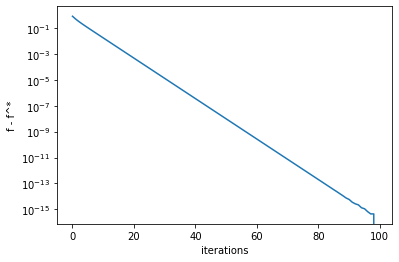

In [22]:
f_star = ridge_cost(w_star, X, y, lbda)
f_vals = [ridge_cost(w, X, y, lbda) - f_star for w in w_list]

plt.semilogy(f_vals)
plt.xlabel('iterations')
plt.ylabel('f - f^*')

Text(0, 0.5, '||x - x^*||')

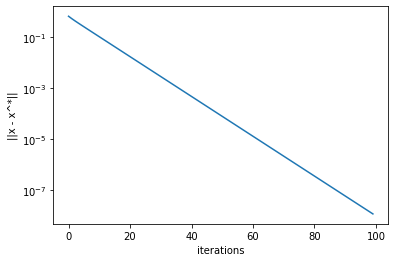

In [23]:
dists = [np.linalg.norm(w - w_star) for w in w_list]

plt.semilogy(dists)
plt.xlabel('iterations')
plt.ylabel('||x - x^*||')

**Exercice 4** Give the formula for the conditioning of the problem. Write a function that computes the condition number given $X, y$ and $\lambda$. 

explicit formula of $\kappa$: $\kappa = \frac{\lambda_{min} + \lambda}{\lambda_{max} + \lambda}$

(eigen values of $X^{T}X$ )

In [26]:
def conditioning(
    X, 
    lbda: float
    ) -> float:
    """Determine the kappa constant corresponding to a certain problem

    Parameters
    ----------
    X : [type]
        observation matrix
    lbda : float
        regularization coefficient

    Returns
    -------
    float
        returns the kappa constant
    """

    # param
    sym_matrix = X.T.dot(X)
    # eigen values
    eigen_values = np.linalg.eigvalsh(sym_matrix)

    # constants
    mu = min(eigen_values) + lbda
    L = max(eigen_values) + lbda

    return mu / L

**Exercice 5** Generate a problem with $n=50$, $p=100$ where the conditioning is $~0.5$, and another problem where the conditioning is $~1 / 1000$. Compare the convergence curves on these problems.

In [38]:
# Well conditioned problem
n, p = 50, 100
# your code here
conditioning(X, lbda=0.1)

0.147569045242899

In order to get a very bad conditioning, we can generate a very badly conditioned matrix $X$ as $U\Sigma V$ where $U$, $V$ are random orthogonal matrices and $\Sigma$ is badly conditioned.

In [89]:
from scipy.linalg import qr

# Poorly conditioned problem
n, p = 50, 100


# generate random matrix X (n, p)
H = np.random.randn(n, p)
Q, R = qr(H)

# create diagonal 
max_sigma = 10 ** 2
diagonal = np.array(
    # diagonal
    [max_sigma] + [1 for i in range(p - 1)], 
    dtype=float
)

diag_matrix = np.diag(diagonal)

# create X
X = R.T @ diag_matrix @ Q


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 50)

In [87]:
H.shape

(50, 100)

In [80]:
conditioning(
    X,
    lbda=10
)

0.0012738550000818125